In this notebook we reconstruct the AttnSense model and perform training and evaluation.\
We show results for many experiments conducted, including:
1. Examining model stability
2. Optimizing various parameters
3. Examining the contribution of different components of the model

In [20]:
#imports

# basic
import os 
import sys
import math
from time import time
import pickle

# general
import warnings
import numpy as np
import scipy as sp
import pandas as pd

# visual
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# notebook
from IPython.display import display

# Sklean
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , roc_auc_score , confusion_matrix , f1_score
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

# torch
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential
from torch.nn import Sigmoid,ReLU
from torch.nn import Linear
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam,SGD , RMSprop

from scipy.fft import fft
import gc

from tqdm import tqdm
import copy  # to save best model parameters


## Datasets & Data Loader

In [22]:
path = './train_dev_test_aug1_n20_subject_labels'

with open(path , 'rb') as f:
  train, dev, test = pickle.load(f)
  print('loaded data file')

loaded data file


In [23]:
from torch.utils.data import DataLoader
batch_size = 64
dl_train = DataLoader(train, batch_size=batch_size, shuffle=True)
dl_dev = DataLoader(dev, batch_size=batch_size)
dl_test = DataLoader(test, batch_size=batch_size)

In [24]:
dl_iter = iter(dl_train)
batch = next(dl_iter)
batch[0].shape

torch.Size([64, 20, 27, 13])

### MODEL

There are 4 classes that serve as building blocks for the complete model:
1. A class that applies a CNN to a single axis - within a single time-step [Individual_Conv_single]
2. A class that manages different CNN's for all the axes of a time-step [Individual_Conv]
3. An attention class (soft attention). This is applied both for sensor fusion and for combining time-steps [Attention]
4. Subject_aware_attn, which is a varitation of AttnSense, with additional subject classification feature

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def clear_cache():
    gc.collect()  # garbage collector
    torch.cuda.empty_cache()

In [26]:
class Individual_Conv_single(nn.Module):
  # two options are implemented here, for CNN of 1 layer and of 4 layers
  # They follow the details given in the paper
    def __init__(self ,input_size  , num_conv_layer):
        super(Individual_Conv_single, self).__init__()
        
        layers_conv = []
        layers_fc = []
        dropout = 0
        
        if num_conv_layer == 1:
            conv_features = 64
            layers_conv.append(nn.Conv1d(1, conv_features, 3, stride=1, padding='same'))
            layers_conv.append(nn.Dropout(p=dropout))
            layers_conv.append(nn.BatchNorm1d(conv_features))
            layers_conv.append(nn.ReLU(inplace=True))
            layers_conv.append(nn.MaxPool1d(2, stride=2))
            
           # layers_fc.append(nn.Linear(conv_features*12, input_size)) # without FFT
            layers_fc.append(nn.Linear(conv_features*6, input_size)) # for FFT
        else:  # 4 layers      
            layers_conv.append(nn.Conv1d(1, 32, 3, stride=1, padding='same'))
            layers_conv.append(nn.Dropout(p=dropout))
            layers_conv.append(nn.BatchNorm1d(32))
            layers_conv.append(nn.ReLU(inplace=True))
                
            layers_conv.append(nn.Conv1d(32, 32, 3, stride=1, padding='same'))
            layers_conv.append(nn.Dropout(p=dropout))
            layers_conv.append(nn.BatchNorm1d(32))
            layers_conv.append(nn.ReLU(inplace=True))
            layers_conv.append(nn.MaxPool1d(2, stride=2))
        
            layers_conv.append(nn.Conv1d(32, 64, 3, stride=1, padding='same'))
            layers_conv.append(nn.Dropout(p=dropout))
            layers_conv.append(nn.BatchNorm1d(64))
            layers_conv.append(nn.ReLU(inplace=True))
        
            layers_conv.append(nn.Conv1d(64, 64, 3, stride=1, padding='same'))
            layers_conv.append(nn.BatchNorm1d(64))
            layers_conv.append(nn.ReLU(inplace=True))
            layers_conv.append(nn.MaxPool1d(2, stride=2))
            
           # layers_fc.append(nn.Linear(64*6, input_size)) # without FFT
            layers_fc.append(nn.Linear(64*3, input_size))  # for fft
        
               
        layers_fc.append(nn.ReLU(inplace=True))
            
        self.ind_conv = nn.Sequential(*layers_conv)
        self.ind_fc = nn.Sequential(*layers_fc)
                
    def forward(self, X):  
        X_t = X.unsqueeze(1) # input channel
        out_conv = self.ind_conv(X_t) 
        out_conv_flat = out_conv.view(out_conv.shape[0],-1)
        out = self.ind_fc(out_conv_flat)
        return out

    
class Individual_Conv(nn.Module):
    def __init__(self ,num_features, input_size, num_conv_layer):
        super(Individual_Conv, self).__init__()
        
        self.num_features = num_features
        self.module = []
        
        for feature_num in range(num_features):
            self.module.append(Individual_Conv_single(input_size = input_size, num_conv_layer = num_conv_layer) )
              
            self.add_module("feature_{}_Individual_Conv_single".format(feature_num), \
                            self.module[feature_num])
              
    def forward(self, X): 
          
        out = []
        for feature_num in range(self.num_features):
            out.append(self.module[feature_num](X[:, feature_num,:]) )
            
        return torch.stack(out, dim=1)

In [ ]:
# TEST

X = torch.tensor(batch[0][:, 0, :, :],dtype=torch.float32).to(device)
print(X.shape)
model = Individual_Conv(num_features = X.shape[1] ,  input_size = X.shape[2] , num_conv_layer=1).to(device)
#print(model)
model(X).shape


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


torch.Size([64, 27, 13])


torch.Size([64, 27, 13])

In [27]:
#https://www.kaggle.com/code/mlwhiz/attention-pytorch-and-keras/notebook

class Attention(nn.Module):
    def __init__(self,  input_size):
        super(Attention, self).__init__()
        
        self.input_size = input_size
        # Linear 
        self.linear = nn.Linear(input_size, input_size)
        
        # Conext vector 
        context_weight = torch.zeros(input_size, 1)
        nn.init.kaiming_uniform_(context_weight)
        self.context_weight = nn.Parameter(context_weight)     
     
    def forward(self, X):   # X dim (batch , feature number / step , feature_vect)
        
        num_features = X.shape[1]
        linear = []
        
        X_linear = torch.tanh(self.linear(X))   # X_linear dimension is (Batch , feature , embedding = input_size)
                  
        eij = torch.matmul(X_linear, self.context_weight)     # eij domain is (batch , feature_num,1)

        a = torch.exp(eij)
        
        a = a / (torch.sum(a, dim = 1, keepdim=True) + 1e-10)
                
        weighted_input = X *a

        return torch.sum(weighted_input, 1)   

In [ ]:
# TEST

X = torch.tensor(batch[0][:, 0, :, :],dtype=torch.float32).to(device)
model = Attention(input_size = X.shape[2]).to(device)
model(X).shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


torch.Size([64, 13])

In the following model we implement a variation over AttnSense with subject classification\
The Forward method returns preditions for both subject and classification so that training can be done on two combined losses. 

In [28]:
class Subject_aware_attn(nn.Module):
    def __init__(self, num_features,input_size, num_conv_layer, hidden_size, AG, AF, num_classes, num_subjects, dropout = 0):
        super(Subject_aware_attn, self).__init__()

        self.num_subjects = num_subjects
        self.AG = AG #AG = Attention for combining GRU outputs of timesteps
        self.AF = AF #AF = Attention for fusion of sensors outputs
        
        self.Individual_Conv = Individual_Conv(num_features = num_features,   \
                                                 input_size = input_size, num_conv_layer = num_conv_layer)
        """
        if self.AF == True:
            self.Attention_stage1 = Attention(input_size = input_size)
            gru_input_size = input_size
        else:
            gru_input_size = input_size*num_features # optional for output concatanation if no attention is apllied
        """
        if self.AF == True:
            self.Attention_stage1 = Attention(input_size = input_size)
        gru_input_size = input_size
        
        self.gru = nn.GRU(input_size = gru_input_size, hidden_size = hidden_size, \
                            num_layers = 2, batch_first = True, dropout = dropout , \
                            bidirectional=False)  
        
        if self.AG == True:
            self.Attention_stage2 = Attention(input_size = hidden_size)

        self.fc_subject = nn.Linear(hidden_size, num_subjects)
        self.fc_activity = nn.Linear(hidden_size+num_subjects, num_classes)
        # self.fc_activity = nn.Linear(hidden_size+1, num_classes)
        
    def forward(self, X, sub_label, train = False):   # X dim [Batch , N (word) , feature num , input_size]
        seq_size = X.shape[1]
        Att_stage1 = []
        for seq_size_num in range(seq_size):
            # Individual Conv
            v = self.Individual_Conv(X[:,seq_size_num,:,:])  # Take from x (batch , features , input_size) 
            
            # First layer attension
            if self.AF == True:
                att = self.Attention_stage1(v) 
            else:
                # concat all the features 
                #att = v.view(v.shape[0],-1)
                # mean
                att = v.mean(dim = 1)
                
            Att_stage1.append(att)   
        
        C = torch.stack(Att_stage1 , dim=1)   # C results is (batch , seq_size , input_size)
        
        h_out, hn = self.gru(C)
        
        if self.AG == True:   
            delta = self.Attention_stage2(h_out)  
            #delta = h_out[:,-1,:] 
        else:
            delta = h_out.mean(dim = 1)
        
        output_sub = self.fc_subject(delta)
        if train:
          ones_hot = F.one_hot(sub_label, self.num_subjects)
          delta_plus = torch.concat((delta, ones_hot), dim = 1)
        else:
          # pred_sub = torch.argmax(output_sub, dim = 1).unsqueeze(dim = 1)
          # delta_plus = torch.concat((delta, pred_sub), dim = 1)
          delta_plus = torch.concat((delta, F.softmax(output_sub, dim = 1)), dim = 1)

        output_act = self.fc_activity(delta_plus)
             
        return output_sub, output_act

In [29]:
X = torch.tensor(batch[0],dtype=torch.float32).to(device)
model = Subject_aware_attn(num_features = X.shape[2] , input_size = X.shape[3] , num_conv_layer = 4  \
                  , hidden_size = 50, AG = True, AF = True, num_classes = 12, num_subjects = 9).to(device)

lr = 1e-4
optimizer  = Adam(model.parameters(), lr=lr , weight_decay = 1e-4) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


## Training

1. The training uses a cross-entropy loss for both subject and activity classification and Adam optimizer with learning rate and weight decay at 1e-4.
2. subject and activity losses are weighted using a parameter alpha.
3. With each epoch we evaluate accuracy, loss and f1-score on the dev dataset.
4. Stopping criteria is when f1-score for dev has not improved for 10 epochs. The best model is always saved and reloaded.

Below we define our "base model" with the recommended configuration of the paper:
* 4 covolution layers
* window size of N=20

We run the model over data **without augmentation**.

In [30]:
# Ref: https://mccormickml.com/2019/07/22/BERT-fine-tuning/#41-bertforsequenceclassification
            
def train_loop(model, optimizer , n_epochs, dl_train, dl_dev,device , early_stopping = 10,  verbose=False, alpha = 0.2):
  # Loss function
  criterion1 = nn.CrossEntropyLoss()
  criterion2 = nn.CrossEntropyLoss()
 
  for e in range(1, n_epochs + 1):
    loss_train_arr = []
    loss_dev_arr = []
    acc_train_arr = []
    acc_dev_arr = []
    f1_train_arr = []
    f1_dev_arr = []

    loss_train_arr_sub = []
    loss_dev_arr_sub = []
    # acc_train_arr_sub = []
    # acc_dev_arr_sub = []
    f1_train_arr_sub = []
    f1_dev_arr_sub = []
     
    epochs_without_improvement = 0
    best_dev_loss = None 
    best_dev_acc = None
    best_dev_f1 = None
    
    for epoch in range(1, n_epochs + 1):
        
        #################
        ### Train loop ##
        ################
        model.train()
        train_loss = 0
        train_loss_sub = 0
        train_acc = 0
        y_true = []
        y_pred = []
        y_true_sub = []
        y_pred_sub = []
        
        for batch in tqdm(dl_train, disable=(not verbose)):
            data, label = batch      
            # Send tensors to GPU
            data = data.to(device)
            act_label = label[0]
            sub_label = label[1]
            act_label = act_label.to(device) 
            sub_label = sub_label.to(device)          
               
            pred_sub, pred_act = model(data, sub_label, train = True)
            loss_act = criterion2(pred_act, act_label)
            loss_sub = criterion1(pred_sub, sub_label)
            loss = alpha * loss_sub + (1-alpha) * loss_act
                     
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()               
            # agg batch results
            train_loss += loss.item()
            train_loss_sub += loss_sub.item()
            pred_cls = np.argmax(pred_act.detach().to('cpu').numpy(), axis = 1)
            y_true.extend(act_label.detach().to('cpu').numpy())
            y_pred.extend(pred_cls) 
            pred_subject = np.argmax(pred_sub.detach().to('cpu').numpy(), axis = 1)
            y_true_sub.extend(sub_label.detach().to('cpu').numpy())
            y_pred_sub.extend(pred_subject) 
            
        # Agg epoch results 
        train_loss = train_loss / len(dl_train) 
        train_loss_sub = train_loss_sub / len(dl_train)            
        loss_train_arr.append(train_loss) 
        loss_train_arr_sub.append(train_loss_sub)        
        train_acc = accuracy_score(y_true, y_pred)          
        acc_train_arr.append(train_acc)
        train_f1  = f1_score(y_true, y_pred,sample_weight=None, average  = 'weighted', zero_division='warn')
        f1_train_arr.append(train_f1)
        train_f1_sub  = f1_score(y_true_sub, y_pred_sub,sample_weight=None, average  = 'weighted', zero_division='warn')
        f1_train_arr_sub.append(train_f1_sub)
   
        ####################
        # Dev  evaluation #
        ###################
        dev_loss = 0
        dev_acc = 0
        y_true = []
        y_pred = []
        dev_loss_sub = 0
        # dev_acc = 0
        y_true_sub = []
        y_pred_sub = []
        
        model.eval()
        with torch.no_grad():
            for batch  in tqdm(dl_dev, disable=(not verbose)):
                data, label = batch      
                # Send tensors to GPU
                data = data.to(device)               
                act_label = label[0]
                sub_label = label[1]
                act_label = act_label.to(device) 
                sub_label = sub_label.to(device)            
                  
                pred_sub, pred_act = model(data, sub_label, train = False)
                loss_act = criterion2(pred_act, act_label)
                loss_sub = criterion1(pred_sub, sub_label)
                loss = alpha * loss_sub + (1-alpha) * loss_act

                # Agg results
                dev_loss += loss.item()
                dev_loss_sub += loss_sub.item()
                pred_cls = np.argmax(pred_act.detach().to('cpu').numpy(), axis = 1)
                y_true.extend(act_label.detach().to('cpu').numpy())
                y_pred.extend(pred_cls) 
                pred_subject = np.argmax(pred_sub.detach().to('cpu').numpy(), axis = 1)
                y_true_sub.extend(sub_label.detach().to('cpu').numpy())
                y_pred_sub.extend(pred_subject) 
                
            # Agg epoch results 
        dev_loss = dev_loss / len(dl_dev)  
        dev_loss_sub = dev_loss_sub / len(dl_dev)         
        loss_dev_arr.append(dev_loss)    
        loss_dev_arr_sub.append(dev_loss_sub)    
        dev_acc = accuracy_score(y_true, y_pred)          
        acc_dev_arr.append(dev_acc)
        dev_f1 = f1_score(y_true, y_pred,sample_weight=None, average = 'weighted', zero_division = 'warn')
        f1_dev_arr.append(dev_f1)
        dev_f1_sub = f1_score(y_true_sub, y_pred_sub,sample_weight=None, average = 'weighted', zero_division = 'warn')
        f1_dev_arr_sub.append(dev_f1_sub)
            
        # Early Stop and best model save
        # if not best_dev_loss or dev_loss < best_dev_loss:
        #if not best_dev_acc or dev_acc > best_dev_acc:
        if not best_dev_f1 or dev_f1 > best_dev_f1:
            best_train_loss = train_loss
            best_dev_loss = dev_loss
            best_train_acc = train_acc
            best_dev_acc = dev_acc
            best_train_f1 = train_f1
            best_dev_f1 = dev_f1
            epochs_without_improvement = 0
            #print ("Achieved lower dev loss, save model at epoch number {} ".format(epoch + 1) )
            best_state_dict = copy.deepcopy(model.state_dict())
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement == early_stopping:
            if verbose == True:
                print ("\nEarly stoping after {} epochs. Dev loss did not imporve for more than {} epcochs".format(epoch,early_stopping))
            break
            
        #if (verbose) & (epoch % 5 == 1):   #  report every 10% of the number of epoch
        if  epoch % 5 == 1:   #  report every 10% of the number of epoch
        #if True:
            print("\nEpoch {epoch_id}".format(epoch_id=epoch))
            print("Train loss  : {:.3f}".format(train_loss),end=',   ')
            print("Dev loss    : {:.3f}".format(dev_loss))
            print("Train acc  : {:.3f}".format(train_acc),end=',   ')
            print("Dev acc    : {:.3f}".format(dev_acc))
            print("Train f1    : {:.3f}".format(train_f1),end=',   ')
            print("Dev f1    : {:.3f}".format(dev_f1))
            clear_cache()
            
                  
    # Finish  training 
    model.load_state_dict(best_state_dict)
    if (verbose):
        print('\nFinished Training:')
        print('Train loss ={:.3f}, Dev loss ={:.3f}'.format(best_train_loss ,best_dev_loss ))
        print('Train acc ={:.3f}, Dev acc ={:.3f}'.format(best_train_acc ,best_dev_acc ))
        print('Train F1 score ={:.3f}, Dev F1 score={:.3f}'.format(best_train_f1 ,best_dev_f1 ))
       
        
    return loss_train_arr[1::] , loss_dev_arr[1::] , acc_train_arr[1::] , acc_dev_arr[1::] , f1_train_arr[1::] , f1_dev_arr[1::], loss_train_arr_sub[1::] , loss_dev_arr_sub[1::] , f1_train_arr_sub[1::] , f1_dev_arr_sub[1::]

In [31]:
def loss_graph(loss_train_arr , loss_dev_arr , f1_train_arr , f1_dev_arr , title1, title2, test_name = 'Dev'):
  #show learning progress
    fig, ax = plt.subplots(1, 2,figsize=(14, 5))

    ax[0].set_title(title1)
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[0].plot(loss_train_arr,label="Train loss")
    ax[0].plot(loss_dev_arr,  label="{} loss".format(test_name))
    ax[0].legend()
        
    ax[1].set_title(title2)
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('F1 score')
    ax[1].plot(f1_train_arr,  label="Train F1")
    ax[1].plot(f1_dev_arr,  label="{} F1".format(test_name))
    ax[1].legend()    

## EVALUATION

Evaluation is done on the test set, reporting precision, recall and f1-score for all classes. The weighted f1-score is the main reported measure.\
The confusion measure is also presented.

In [32]:
activity_names = ['lying', 'sitting', 'standing', 'walking', 'running', 'cycling', 'Nordic_walking', \
                  'ascending_stairs', 'descending_stairs', 'vacuum_cleaning', 'ironing', 'rope_jumping']

In [33]:
def evaluate(model, dl , caption, plot_cm , print_scores,  verbose=False , cm_perventage = True):
    
    if print_scores == True:
        print(caption,"\n")
        
    y_true_act = []
    y_pred_act = []
    y_true_sub = []
    y_pred_sub = []
    
    model.eval()
    with torch.no_grad():
        for batch in tqdm(dl, disable=(not verbose)):
            data, label = batch      
            # Send tensors to GPU
            data = data.to(device)
            act_label = label[0]
            sub_label = label[1]
              
            pred_sub, pred_act = model(data, sub_label, train = False)
               
            # Agg results
            pred_cls = np.argmax(pred_act.detach().to('cpu').numpy() , axis = 1)
            y_true_act.extend(act_label.detach().to('cpu').numpy().tolist())
            y_pred_act.extend(pred_cls) 
            pred_sub = np.argmax(pred_sub.detach().to('cpu').numpy() , axis = 1)
            y_true_sub.extend(sub_label.detach().to('cpu').numpy().tolist())
            y_pred_sub.extend(pred_sub) 
    
    y_true_arr_act = np.array(y_true_act)
    y_pred_arr_act = np.array(y_pred_act)
    y_true_arr_sub = np.array(y_true_sub)
    y_pred_arr_sub = np.array(y_pred_sub)
    
    classes = np.union1d(y_true_arr_act, y_pred_arr_act)
    # tick_names = activity_names
    tick_names = [activity_names[c] for c in classes]
    ## Confusion Matrix - Multi class ## 
    if plot_cm == True:
        cnf_matrix = metrics.confusion_matrix(y_true_arr_act, y_pred_arr_act)
        if cm_perventage == True:
            cnf_matrix = cnf_matrix / cnf_matrix.sum(axis=1).reshape(-1,1)
            cnf_matrix = np.around(cnf_matrix, 2)
        fig, ax = plt.subplots(figsize=(16, 8))
        tick_marks = np.arange(len(tick_names))
        # print(cnf_matrix.shape, len(tick_names))

        if cm_perventage == True:
            sns.heatmap(pd.DataFrame(data=cnf_matrix, index=tick_names, columns=tick_names), \
                        annot=True, cmap="Blues",fmt='g' , vmin = 0 , vmax = 1)
        else:
            sns.heatmap(pd.DataFrame(data=cnf_matrix, index=tick_names, columns=tick_names), annot=True, cmap="YlGnBu",fmt='g')
        ax.xaxis.set_label_position("top")
        plt.tight_layout()
        plt.title('Confusion Matrix', y=1.1)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        
    # Scores #
    f1_s = f1_score(y_true_arr_act, y_pred_arr_act, sample_weight=None, average  = 'weighted', zero_division='warn')
    m1 = metrics.classification_report(y_true_arr_act, y_pred_arr_act, target_names = tick_names, output_dict=True, digits=3, zero_division = 0)
    
    f1_all = m1['weighted avg']['f1-score']
        
    if print_scores == True:
        print(metrics.classification_report(y_true_arr_act, y_pred_arr_act, target_names = tick_names,digits=3, zero_division = 0  ))
        print(f1_s)

  ######################################
    subjs = np.union1d(y_true_arr_sub, y_pred_arr_sub)
    sub_id = np.arange(8).astype('str')
    tick_names = [sub_id[s] for s in subjs]
    ## Confusion Matrix - Multi class ## 
    if plot_cm == True:
        cnf_matrix = metrics.confusion_matrix(y_true_arr_sub, y_pred_arr_sub)
        if cm_perventage == True:
            cnf_matrix = cnf_matrix / cnf_matrix.sum(axis=1).reshape(-1,1)
            cnf_matrix = np.around(cnf_matrix, 2)
        fig, ax = plt.subplots(figsize=(16, 8))
        tick_marks = np.arange(len(tick_names))
        # print(cnf_matrix.shape, len(tick_names))

        if cm_perventage == True:
            sns.heatmap(pd.DataFrame(data=cnf_matrix, index=tick_names, columns=tick_names), \
                        annot=True, cmap="Blues",fmt='g' , vmin = 0 , vmax = 1)
        else:
            sns.heatmap(pd.DataFrame(data=cnf_matrix, index=tick_names, columns=tick_names), annot=True, cmap="YlGnBu",fmt='g')
        ax.xaxis.set_label_position("top")
        plt.tight_layout()
        plt.title('Confusion Matrix', y=1.1)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        
    # # Scores #
    # f1_sub = f1_score(y_true_arr_sub, y_pred_arr_sub, sample_weight=None, average  = 'weighted', zero_division='warn')
    # # m1 = metrics.classification_report(y_true_arr_sub, y_pred_arr_sub, target_names = tick_names, output_dict=True, digits=3, zero_division = 0)
    
    # # f1_all = m1['weighted avg']['f1-score']
        
    # if print_scores == True:
    #     print(metrics.classification_report(y_true_arr_sub, y_pred_arr_sub, target_names = tick_names,digits=3, zero_division = 0  ))
    #     print(f1_sub)
    
    return f1_s

In [ ]:
# base_model_results = np.array([0.9, 0.9, 0.888, 0.888, 0.864, 0.892, 0.87, 0.92, 0.877, 0.852, 0.917, 0.878, 0.922, 0.891, 0.856, 0.92, 0.928, 0.9252, 0.855, 0.915, 0.885, 0.857, 0.925, 0.892, 0.829, 0.924, 0.902, 0.837, 0.932])
# alpha_02_results = np.array([0.9, 0.875])
# # alpha_05_results = np.array([0.864]) # with stop on f1-score
# print('Mean f1-score for base model is ', np.mean(alpha_02_results))
# print('f1-score std for base model is ', np.std(alpha_02_results))
# alpha 0.3 0.878

In [34]:
X = torch.tensor(batch[0],dtype=torch.float32).to(device)
model = Subject_aware_attn(num_features = X.shape[2] , input_size = X.shape[3] , num_conv_layer = 4  \
                  , hidden_size = 50, AG = True, AF = True, num_classes = 12, num_subjects = 9).to(device)

lr = 1e-4
optimizer  = Adam(model.parameters(), lr=lr , weight_decay = 1e-4) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


Run for alpha = 0.4 (one of many runs for different alphas)

100%|██████████| 7/7 [00:03<00:00,  2.11it/s]



Epoch 1
Train loss  : 2.292,   Dev loss    : 2.183
Train acc  : 0.238,   Dev acc    : 0.405
Train f1    : 0.192,   Dev f1    : 0.292


100%|██████████| 7/7 [00:03<00:00,  2.16it/s]



Epoch 6
Train loss  : 1.613,   Dev loss    : 1.550
Train acc  : 0.576,   Dev acc    : 0.623
Train f1    : 0.485,   Dev f1    : 0.541


100%|██████████| 7/7 [00:03<00:00,  2.11it/s]



Epoch 11
Train loss  : 1.381,   Dev loss    : 1.314
Train acc  : 0.704,   Dev acc    : 0.795
Train f1    : 0.671,   Dev f1    : 0.774


100%|██████████| 7/7 [00:03<00:00,  2.07it/s]



Epoch 16
Train loss  : 1.223,   Dev loss    : 1.177
Train acc  : 0.799,   Dev acc    : 0.842
Train f1    : 0.781,   Dev f1    : 0.824


100%|██████████| 7/7 [00:03<00:00,  2.12it/s]



Epoch 21
Train loss  : 1.116,   Dev loss    : 1.084
Train acc  : 0.851,   Dev acc    : 0.888
Train f1    : 0.847,   Dev f1    : 0.888


100%|██████████| 7/7 [00:03<00:00,  2.08it/s]



Epoch 26
Train loss  : 1.037,   Dev loss    : 1.012
Train acc  : 0.901,   Dev acc    : 0.914
Train f1    : 0.901,   Dev f1    : 0.914


100%|██████████| 7/7 [00:03<00:00,  2.11it/s]



Epoch 31
Train loss  : 0.975,   Dev loss    : 0.978
Train acc  : 0.915,   Dev acc    : 0.912
Train f1    : 0.915,   Dev f1    : 0.912


100%|██████████| 7/7 [00:03<00:00,  2.15it/s]



Epoch 36
Train loss  : 0.927,   Dev loss    : 0.939
Train acc  : 0.928,   Dev acc    : 0.914
Train f1    : 0.928,   Dev f1    : 0.915


100%|██████████| 7/7 [00:03<00:00,  2.11it/s]



Epoch 41
Train loss  : 0.886,   Dev loss    : 0.903
Train acc  : 0.938,   Dev acc    : 0.923
Train f1    : 0.938,   Dev f1    : 0.924


100%|██████████| 7/7 [00:03<00:00,  2.15it/s]



Epoch 46
Train loss  : 0.849,   Dev loss    : 0.902
Train acc  : 0.943,   Dev acc    : 0.921
Train f1    : 0.944,   Dev f1    : 0.921


100%|██████████| 7/7 [00:03<00:00,  2.11it/s]



Epoch 51
Train loss  : 0.817,   Dev loss    : 0.849
Train acc  : 0.944,   Dev acc    : 0.935
Train f1    : 0.944,   Dev f1    : 0.935


100%|██████████| 7/7 [00:03<00:00,  2.12it/s]



Epoch 56
Train loss  : 0.781,   Dev loss    : 0.818
Train acc  : 0.952,   Dev acc    : 0.935
Train f1    : 0.953,   Dev f1    : 0.935


100%|██████████| 7/7 [00:03<00:00,  2.13it/s]



Early stoping after 59 epochs. Dev loss did not imporve for more than 10 epcochs

Finished Training:
Train loss =0.828, Dev loss =0.850
Train acc =0.943, Dev acc =0.944
Train F1 score =0.943, Dev F1 score=0.945
Classifier results 

                   precision    recall  f1-score   support

            lying      0.983     0.934     0.958        61
          sitting      0.785     0.850     0.816        60
         standing      0.680     0.531     0.596        64
          walking      0.940     0.926     0.933        68
          running      1.000     0.966     0.983        59
          cycling      0.926     0.926     0.926        54
   Nordic_walking      0.986     1.000     0.993        70
 ascending_stairs      0.609     0.848     0.709        33
descending_stairs      0.933     0.519     0.667        27
  vacuum_cleaning      0.710     0.891     0.790        55
          ironing      0.806     0.798     0.802        99

         accuracy                          0.849       65

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide


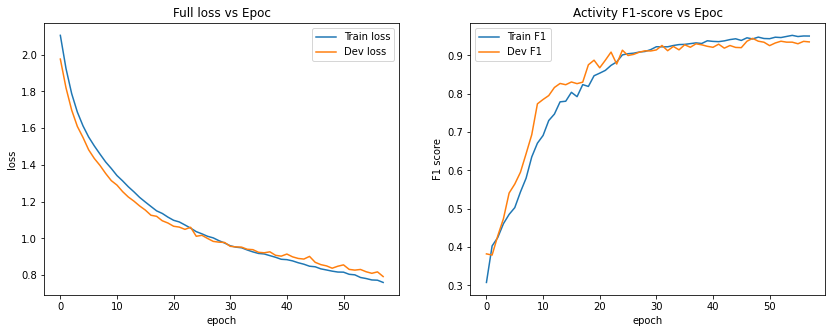

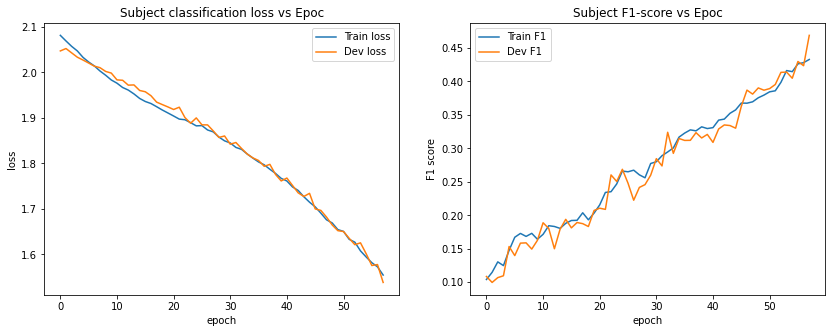

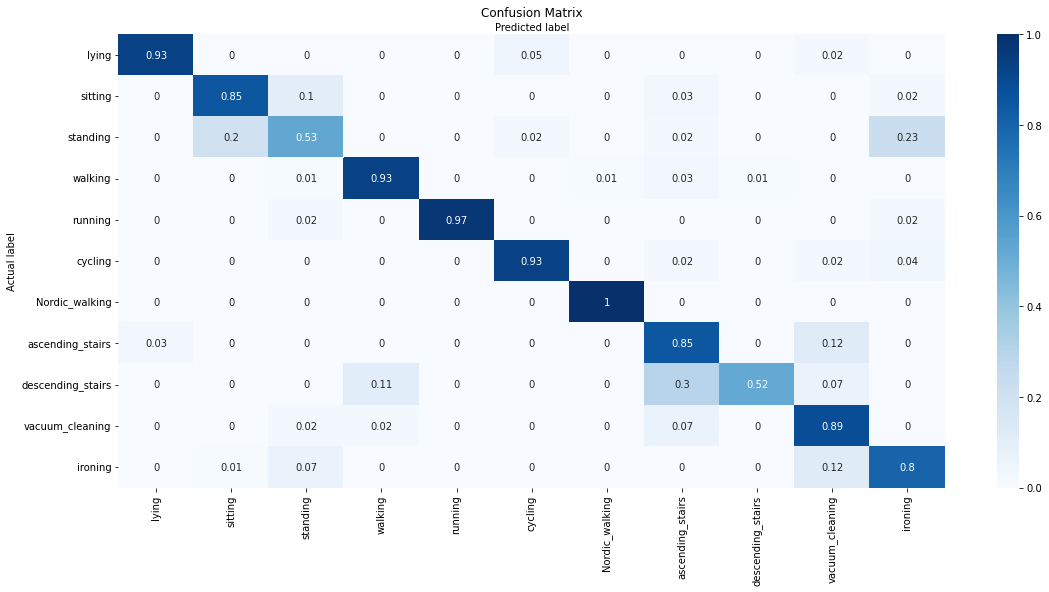

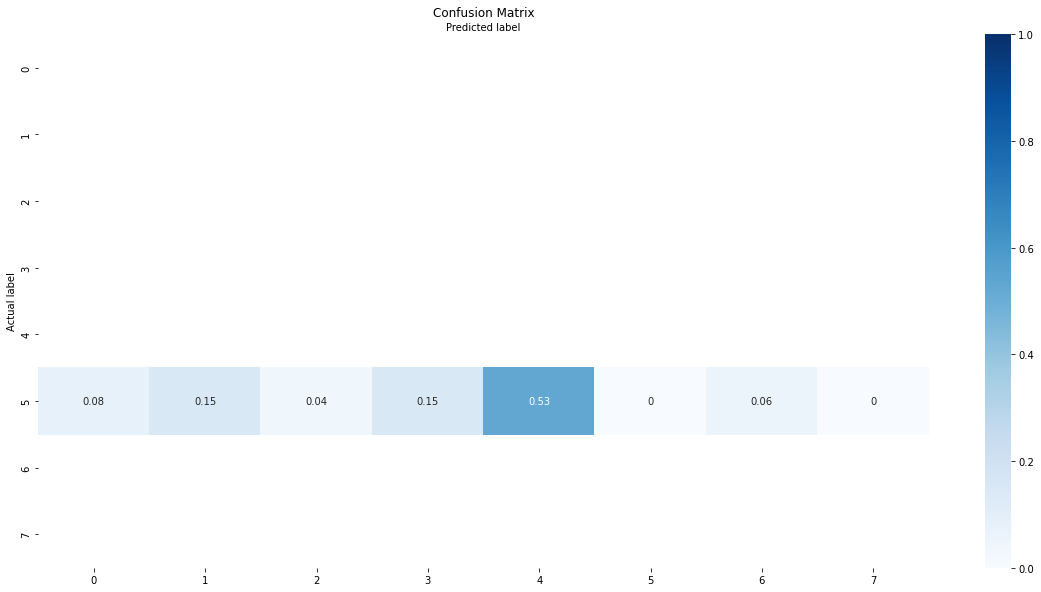

In [35]:
for i in range(1):
  model = Subject_aware_attn(num_features = X.shape[2] , input_size = X.shape[3] , num_conv_layer = 4  \
                    , hidden_size = 50, AG = True, AF = True, num_classes = 12, num_subjects = 9).to(device)

  lr = 1e-4
  optimizer  = Adam(model.parameters(), lr=lr , weight_decay = 1e-4) 

  # Run training
  # loss_train_arr, loss_dev_arr, acc_train_arr, acc_dev_arr, f1_train_arr, f1_dev_arr = \
  #     train_loop(model = model, optimizer = optimizer, n_epochs=100, dl_train  = dl_train, dl_dev = dl_dev, \
  #              device = device , early_stopping = 10, verbose=True, alpha = 0.2)

  loss_train_arr, loss_dev_arr, acc_train_arr, acc_dev_arr, f1_train_arr, f1_dev_arr, loss_train_arr_sub, loss_dev_arr_sub, f1_train_arr_sub, f1_dev_arr_sub = \
    train_loop(model = model, optimizer = optimizer, n_epochs=100, dl_train  = dl_train, dl_dev = dl_dev, \
               device = device , early_stopping = 10, verbose=True, alpha = 0.4)
      
  # loss_graph(loss_train_arr , loss_dev_arr , f1_train_arr , f1_dev_arr)

  loss_graph(loss_train_arr , loss_dev_arr , f1_train_arr , f1_dev_arr, 'Full loss vs Epoc', 'Activity F1-score vs Epoc')
  loss_graph(loss_train_arr_sub , loss_dev_arr_sub , f1_train_arr_sub , f1_dev_arr_sub, 'Subject classification loss vs Epoc', 'Subject F1-score vs Epoc')

  f1_s_model_cls  = evaluate(model = model, dl = dl_test, caption = "Classifier results" ,\
                                               plot_cm = True, print_scores = True)

Since we see that subject classification doesn't converge fast enough, we ran for 220 epochs without stopping:

100%|██████████| 7/7 [00:03<00:00,  2.13it/s]



Epoch 1
Train loss  : 2.317,   Dev loss    : 2.225
Train acc  : 0.194,   Dev acc    : 0.395
Train f1    : 0.165,   Dev f1    : 0.255


100%|██████████| 7/7 [00:03<00:00,  2.11it/s]



Epoch 6
Train loss  : 1.552,   Dev loss    : 1.492
Train acc  : 0.676,   Dev acc    : 0.700
Train f1    : 0.609,   Dev f1    : 0.628


100%|██████████| 7/7 [00:03<00:00,  2.12it/s]



Epoch 11
Train loss  : 1.296,   Dev loss    : 1.280
Train acc  : 0.770,   Dev acc    : 0.742
Train f1    : 0.733,   Dev f1    : 0.687


100%|██████████| 7/7 [00:03<00:00,  2.13it/s]



Epoch 16
Train loss  : 1.182,   Dev loss    : 1.169
Train acc  : 0.806,   Dev acc    : 0.795
Train f1    : 0.772,   Dev f1    : 0.752


100%|██████████| 7/7 [00:03<00:00,  2.12it/s]



Epoch 21
Train loss  : 1.119,   Dev loss    : 1.137
Train acc  : 0.822,   Dev acc    : 0.779
Train f1    : 0.792,   Dev f1    : 0.737


100%|██████████| 7/7 [00:03<00:00,  2.00it/s]



Epoch 26
Train loss  : 1.068,   Dev loss    : 1.088
Train acc  : 0.860,   Dev acc    : 0.865
Train f1    : 0.854,   Dev f1    : 0.864


100%|██████████| 7/7 [00:03<00:00,  2.11it/s]



Epoch 31
Train loss  : 1.029,   Dev loss    : 1.062
Train acc  : 0.874,   Dev acc    : 0.870
Train f1    : 0.872,   Dev f1    : 0.870


100%|██████████| 7/7 [00:03<00:00,  2.09it/s]



Epoch 36
Train loss  : 0.974,   Dev loss    : 0.994
Train acc  : 0.911,   Dev acc    : 0.923
Train f1    : 0.910,   Dev f1    : 0.925


100%|██████████| 7/7 [00:03<00:00,  2.12it/s]



Epoch 41
Train loss  : 0.933,   Dev loss    : 0.932
Train acc  : 0.930,   Dev acc    : 0.953
Train f1    : 0.930,   Dev f1    : 0.954


100%|██████████| 7/7 [00:03<00:00,  2.13it/s]



Epoch 46
Train loss  : 0.898,   Dev loss    : 0.913
Train acc  : 0.939,   Dev acc    : 0.935
Train f1    : 0.939,   Dev f1    : 0.935


100%|██████████| 7/7 [00:03<00:00,  2.00it/s]



Epoch 51
Train loss  : 0.869,   Dev loss    : 0.901
Train acc  : 0.948,   Dev acc    : 0.933
Train f1    : 0.948,   Dev f1    : 0.933


100%|██████████| 7/7 [00:03<00:00,  2.10it/s]



Epoch 56
Train loss  : 0.847,   Dev loss    : 0.877
Train acc  : 0.949,   Dev acc    : 0.953
Train f1    : 0.949,   Dev f1    : 0.954


100%|██████████| 7/7 [00:03<00:00,  2.12it/s]



Epoch 61
Train loss  : 0.823,   Dev loss    : 0.850
Train acc  : 0.954,   Dev acc    : 0.949
Train f1    : 0.954,   Dev f1    : 0.949


100%|██████████| 7/7 [00:03<00:00,  2.11it/s]



Epoch 66
Train loss  : 0.797,   Dev loss    : 0.829
Train acc  : 0.955,   Dev acc    : 0.951
Train f1    : 0.955,   Dev f1    : 0.952


100%|██████████| 7/7 [00:03<00:00,  2.11it/s]



Epoch 71
Train loss  : 0.767,   Dev loss    : 0.819
Train acc  : 0.962,   Dev acc    : 0.944
Train f1    : 0.962,   Dev f1    : 0.945


100%|██████████| 7/7 [00:03<00:00,  2.06it/s]



Epoch 76
Train loss  : 0.745,   Dev loss    : 0.791
Train acc  : 0.962,   Dev acc    : 0.956
Train f1    : 0.963,   Dev f1    : 0.957


100%|██████████| 7/7 [00:03<00:00,  2.13it/s]



Epoch 81
Train loss  : 0.715,   Dev loss    : 0.777
Train acc  : 0.965,   Dev acc    : 0.942
Train f1    : 0.965,   Dev f1    : 0.943


100%|██████████| 7/7 [00:03<00:00,  2.10it/s]



Epoch 86
Train loss  : 0.685,   Dev loss    : 0.790
Train acc  : 0.968,   Dev acc    : 0.944
Train f1    : 0.968,   Dev f1    : 0.945


100%|██████████| 7/7 [00:03<00:00,  2.11it/s]



Epoch 91
Train loss  : 0.651,   Dev loss    : 0.722
Train acc  : 0.967,   Dev acc    : 0.951
Train f1    : 0.967,   Dev f1    : 0.951


100%|██████████| 7/7 [00:03<00:00,  2.11it/s]



Epoch 96
Train loss  : 0.619,   Dev loss    : 0.705
Train acc  : 0.970,   Dev acc    : 0.956
Train f1    : 0.970,   Dev f1    : 0.956


100%|██████████| 7/7 [00:03<00:00,  2.10it/s]



Epoch 101
Train loss  : 0.585,   Dev loss    : 0.671
Train acc  : 0.971,   Dev acc    : 0.944
Train f1    : 0.971,   Dev f1    : 0.944


100%|██████████| 7/7 [00:03<00:00,  2.17it/s]



Epoch 106
Train loss  : 0.553,   Dev loss    : 0.648
Train acc  : 0.970,   Dev acc    : 0.944
Train f1    : 0.971,   Dev f1    : 0.945


100%|██████████| 7/7 [00:03<00:00,  2.07it/s]



Epoch 111
Train loss  : 0.512,   Dev loss    : 0.647
Train acc  : 0.974,   Dev acc    : 0.933
Train f1    : 0.974,   Dev f1    : 0.933


100%|██████████| 7/7 [00:03<00:00,  2.11it/s]



Epoch 116
Train loss  : 0.484,   Dev loss    : 0.563
Train acc  : 0.973,   Dev acc    : 0.956
Train f1    : 0.973,   Dev f1    : 0.956


100%|██████████| 7/7 [00:03<00:00,  2.12it/s]



Epoch 121
Train loss  : 0.454,   Dev loss    : 0.525
Train acc  : 0.973,   Dev acc    : 0.963
Train f1    : 0.973,   Dev f1    : 0.963


100%|██████████| 7/7 [00:03<00:00,  2.13it/s]



Epoch 126
Train loss  : 0.414,   Dev loss    : 0.535
Train acc  : 0.978,   Dev acc    : 0.942
Train f1    : 0.978,   Dev f1    : 0.942


100%|██████████| 7/7 [00:03<00:00,  2.11it/s]



Epoch 131
Train loss  : 0.394,   Dev loss    : 0.512
Train acc  : 0.975,   Dev acc    : 0.942
Train f1    : 0.975,   Dev f1    : 0.943


100%|██████████| 7/7 [00:03<00:00,  2.12it/s]



Epoch 136
Train loss  : 0.362,   Dev loss    : 0.489
Train acc  : 0.979,   Dev acc    : 0.942
Train f1    : 0.979,   Dev f1    : 0.942


100%|██████████| 7/7 [00:03<00:00,  2.11it/s]



Epoch 141
Train loss  : 0.342,   Dev loss    : 0.453
Train acc  : 0.977,   Dev acc    : 0.956
Train f1    : 0.977,   Dev f1    : 0.956


100%|██████████| 7/7 [00:03<00:00,  2.09it/s]



Epoch 146
Train loss  : 0.322,   Dev loss    : 0.506
Train acc  : 0.978,   Dev acc    : 0.926
Train f1    : 0.978,   Dev f1    : 0.927


100%|██████████| 7/7 [00:03<00:00,  2.11it/s]



Epoch 151
Train loss  : 0.291,   Dev loss    : 0.423
Train acc  : 0.981,   Dev acc    : 0.944
Train f1    : 0.981,   Dev f1    : 0.944


100%|██████████| 7/7 [00:03<00:00,  2.12it/s]



Epoch 156
Train loss  : 0.273,   Dev loss    : 0.397
Train acc  : 0.981,   Dev acc    : 0.944
Train f1    : 0.981,   Dev f1    : 0.944


100%|██████████| 7/7 [00:03<00:00,  2.12it/s]



Epoch 161
Train loss  : 0.268,   Dev loss    : 0.368
Train acc  : 0.981,   Dev acc    : 0.958
Train f1    : 0.981,   Dev f1    : 0.959


100%|██████████| 7/7 [00:03<00:00,  2.14it/s]



Epoch 166
Train loss  : 0.244,   Dev loss    : 0.374
Train acc  : 0.982,   Dev acc    : 0.949
Train f1    : 0.982,   Dev f1    : 0.949


100%|██████████| 7/7 [00:03<00:00,  2.12it/s]



Epoch 171
Train loss  : 0.224,   Dev loss    : 0.382
Train acc  : 0.983,   Dev acc    : 0.949
Train f1    : 0.983,   Dev f1    : 0.949


100%|██████████| 7/7 [00:03<00:00,  2.09it/s]



Epoch 176
Train loss  : 0.216,   Dev loss    : 0.387
Train acc  : 0.981,   Dev acc    : 0.937
Train f1    : 0.981,   Dev f1    : 0.938


100%|██████████| 7/7 [00:03<00:00,  2.10it/s]



Epoch 181
Train loss  : 0.207,   Dev loss    : 0.355
Train acc  : 0.980,   Dev acc    : 0.937
Train f1    : 0.980,   Dev f1    : 0.937


100%|██████████| 7/7 [00:03<00:00,  2.11it/s]



Epoch 186
Train loss  : 0.182,   Dev loss    : 0.361
Train acc  : 0.985,   Dev acc    : 0.940
Train f1    : 0.985,   Dev f1    : 0.939


100%|██████████| 7/7 [00:03<00:00,  2.11it/s]



Epoch 191
Train loss  : 0.178,   Dev loss    : 0.335
Train acc  : 0.985,   Dev acc    : 0.947
Train f1    : 0.985,   Dev f1    : 0.947


100%|██████████| 7/7 [00:03<00:00,  2.09it/s]



Epoch 196
Train loss  : 0.180,   Dev loss    : 0.340
Train acc  : 0.982,   Dev acc    : 0.944
Train f1    : 0.982,   Dev f1    : 0.945


100%|██████████| 7/7 [00:03<00:00,  2.10it/s]



Epoch 201
Train loss  : 0.153,   Dev loss    : 0.392
Train acc  : 0.986,   Dev acc    : 0.923
Train f1    : 0.986,   Dev f1    : 0.925


100%|██████████| 7/7 [00:03<00:00,  2.12it/s]



Epoch 206
Train loss  : 0.151,   Dev loss    : 0.358
Train acc  : 0.985,   Dev acc    : 0.935
Train f1    : 0.985,   Dev f1    : 0.935


100%|██████████| 7/7 [00:03<00:00,  2.06it/s]



Epoch 211
Train loss  : 0.144,   Dev loss    : 0.335
Train acc  : 0.984,   Dev acc    : 0.942
Train f1    : 0.984,   Dev f1    : 0.942


100%|██████████| 7/7 [00:03<00:00,  2.05it/s]



Epoch 216
Train loss  : 0.131,   Dev loss    : 0.309
Train acc  : 0.987,   Dev acc    : 0.937
Train f1    : 0.987,   Dev f1    : 0.938


100%|██████████| 7/7 [00:03<00:00,  2.07it/s]



Finished Training:
Train loss =0.454, Dev loss =0.525
Train acc =0.973, Dev acc =0.963
Train F1 score =0.973, Dev F1 score=0.963
Classifier results 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


                   precision    recall  f1-score   support

            lying      0.937     0.967     0.952        61
          sitting      0.889     0.800     0.842        60
         standing      0.920     0.719     0.807        64
          walking      0.922     0.691     0.790        68
          running      1.000     0.983     0.991        59
          cycling      0.981     0.981     0.981        54
   Nordic_walking      0.761     1.000     0.864        70
 ascending_stairs      0.867     0.788     0.825        33
descending_stairs      0.760     0.704     0.731        27
  vacuum_cleaning      0.893     0.909     0.901        55
          ironing      0.836     0.980     0.902        99
     rope_jumping      0.000     0.000     0.000         0

         accuracy                          0.882       650
        macro avg      0.814     0.794     0.799       650
     weighted avg      0.890     0.882     0.880       650

0.8796558640620386


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in true_divide


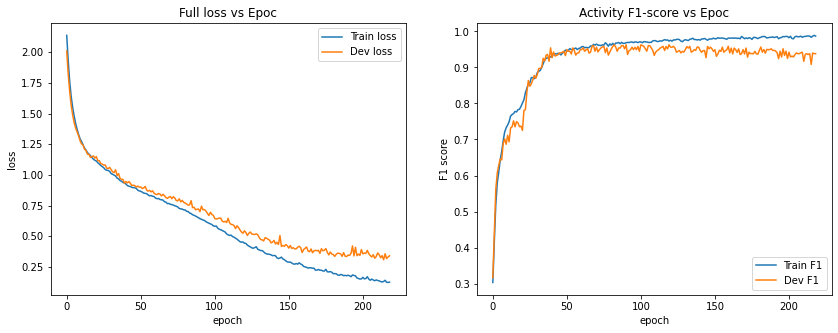

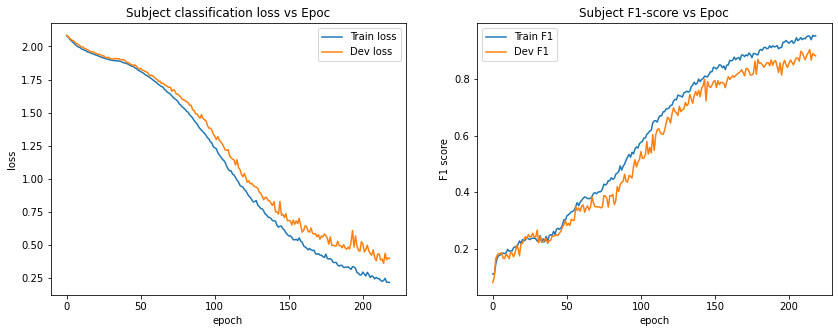

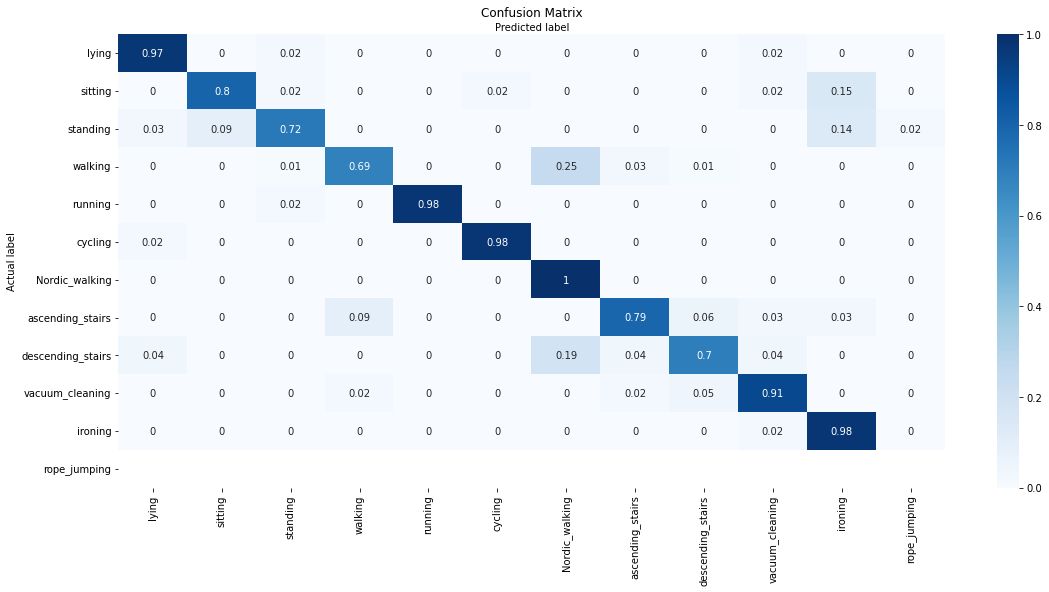

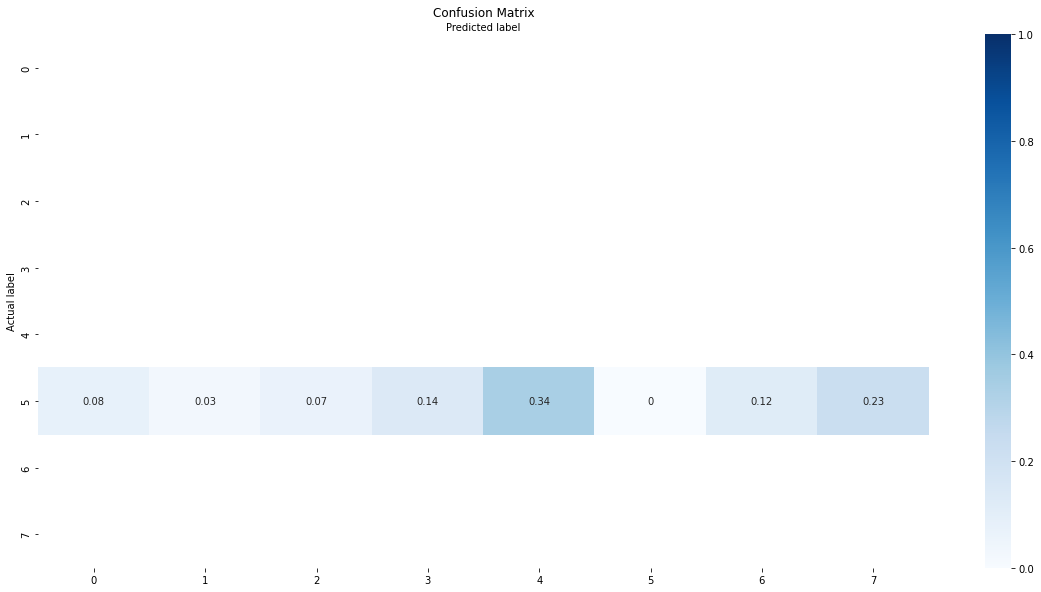

In [ ]:
for i in range(1):
  model = Subject_aware_attn(num_features = X.shape[2] , input_size = X.shape[3] , num_conv_layer = 4  \
                    , hidden_size = 50, AG = True, AF = True, num_classes = 12, num_subjects = 9).to(device)

  lr = 1e-4
  optimizer  = Adam(model.parameters(), lr=lr , weight_decay = 1e-4) 

  # Run training
  # loss_train_arr, loss_dev_arr, acc_train_arr, acc_dev_arr, f1_train_arr, f1_dev_arr = \
  #     train_loop(model = model, optimizer = optimizer, n_epochs=120, dl_train  = dl_train, dl_dev = dl_dev, \
  #              device = device , early_stopping = 10, verbose=True, alpha = 0.2)

  loss_train_arr, loss_dev_arr, acc_train_arr, acc_dev_arr, f1_train_arr, f1_dev_arr, loss_train_arr_sub, loss_dev_arr_sub, f1_train_arr_sub, f1_dev_arr_sub = \
    train_loop(model = model, optimizer = optimizer, n_epochs=220, dl_train  = dl_train, dl_dev = dl_dev, \
               device = device , early_stopping = 200, verbose=True, alpha = 0.4)
      
  # loss_graph(loss_train_arr , loss_dev_arr , f1_train_arr , f1_dev_arr)

  loss_graph(loss_train_arr , loss_dev_arr , f1_train_arr , f1_dev_arr, 'Full loss vs Epoc', 'Activity F1-score vs Epoc')
  loss_graph(loss_train_arr_sub , loss_dev_arr_sub , f1_train_arr_sub , f1_dev_arr_sub, 'Subject classification loss vs Epoc', 'Subject F1-score vs Epoc')

  f1_s_model_cls  = evaluate(model = model, dl = dl_test, caption = "Classifier results" ,\
                                               plot_cm = True, print_scores = True)

## Summary of results

In [10]:
base_model_results = np.array([0.9, 0.9, 0.888, 0.888, 0.864, 0.892, 0.87, 0.92, 0.877, 0.852, 0.917, 0.878, 0.922, 0.891, 0.856, 0.92, 0.928, 0.9252, 0.855, 0.915, 0.885, 0.857, 0.925, 0.892, 0.829, 0.924, 0.902, 0.837, 0.932])

In [11]:
np.mean(base_model_results)

0.8910758620689655

alpha = 0.2: 0.853, 0.88, 0.9, 0.875, 0.916, 0.898, 0.788, 0.870, 0.850, 0.890, 0.907, 0.9, 0.914 avg- 0.88

for alpha 0.3: 0.892, 0.913, 0.89, 0.78, 0.923 0.912, 0.788, 0.835, avg - 0.866

for alpha = 0.4:
0.916, 0.904, 0.918, 0.855, 0.932, 0.87, 0.902, 0.828 avg - 0.891

for alpha = 0.6: 0.744, 0.785, 0.835 avg - 0.788

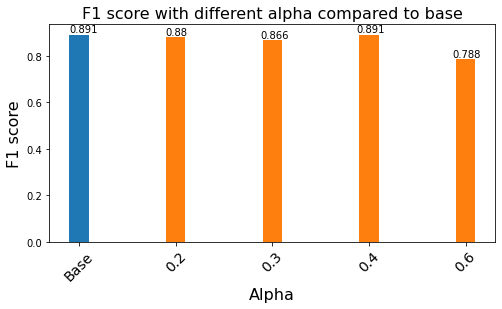

In [18]:
labels = ['Base', '0.2', '0.3', '0.4', '0.6']
averages = [0.88, 0.866, 0.891, 0.788]
x = np.arange(4) + 1
xp = np.arange(5)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
width = 0.2
ax.bar(0, 0.891, width)
ax.bar(x, averages , width)

ax.set_title("F1 score with different alpha compared to base", fontsize=16)
ax.set_ylabel("F1 score", fontsize=16)
ax.set_xlabel("Alpha", fontsize=16)
ax.set_xticks(xp)
ax.set_xticklabels(labels ,fontsize=14,rotation=45)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 0.99, p.get_height() * 1.010))